In [1]:
from qiskit.circuit import *
from qiskit import Aer, execute, BasicAer
from qiskit.tools.visualization import plot_histogram
# https://arxiv.org/abs/2304.01501

In [2]:
# CONVENTIONS
# -1 quand le coin vaut 1, +1 quand il vaut 0
# q_0 encode le bit de poids le plus faible

# Cycle

### Power of two

In [45]:
def increment(n):
    """Quantum circuit implementing the increment operator of Fig. 4 from https://arxiv.org/abs/2304.01501

    Parameters
    ----------
    n : int
        Number of qubit encoding the position

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
    """
    q = QuantumRegister(n,name='q')
    qc = QuantumCircuit(q)
    for i in range(n-1):
        qc.mcx(qc.qubits[:n-i-1],q[n-i-1])
    qc.x(q[0])    
    return qc

def preincrement(n,first_method=True):
    """Quantum circuit implementing the pre-increment operator of Fig. 4 from https://arxiv.org/abs/2304.01501

    Parameters
    ----------
    n : int
        Number of qubit encoding the position
    first_method : bool
        Indicates which methods is used, if True it corresponds to the quantum circuit
        of Fig. 4.a, otherwise Fig. 4.b from https://arxiv.org/abs/2304.01501
        
    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
    """
    q = QuantumRegister(n,name='q')
    c = QuantumRegister(1,name='c')
    qc = QuantumCircuit(q,c)
    if first_method:
        qc.mcx([c[0]],q[n-1])
        for i in range(n-1):
            qc.cx(control,q[n-i-2])
    else:
        for i in range(n-1):
            qc.cx(q[i+1],q[i])
        qc.cx(c[0],q[n-1])
        for i in range(n-1):
            qc.cx(q[n-i-1],q[n-i-2])
    return qc
    
def shift_cycle_power_of_two(n,first_method=True):
    """Quantum circuit implementing the shift operator for a cycle whose size is a power of two

    Parameters
    ----------
    n : int
        Number of qubit encoding the position
    first_method : bool
        Indicates which methods is used to build the pre-increment operator
        if True it corresponds to the quantum circuit of Fig. 4.a, otherwise Fig. 4.b 
        from https://arxiv.org/abs/2304.01501

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
    """
    q = QuantumRegister(n,name='q')
    c = QuantumRegister(1,name='c')
    qc = QuantumCircuit(q,c)
    preincrement_gate = preincrement(n,first_method)
    increment_gate = increment(n)
    qc.append(preincrement_gate,qc.qubits)
    qc.append(increment_gate,qc.qubits[:n])
    qc.append(preincrement_gate,qc.qubits)
    return qc

In [46]:
def run_qc(qc,n_times):
    """Executes a quantum circuit

    Parameters
    ----------
    qc : qiskit.circuit.quantumcircuit.QuantumCircuit
        Quantum circuit to run
    n_times : int
        Number of times to execute it

    Returns
    -------
    dict
    """
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(qc,backend,shots=n_times)
    return dict(job.result().get_counts(qc))

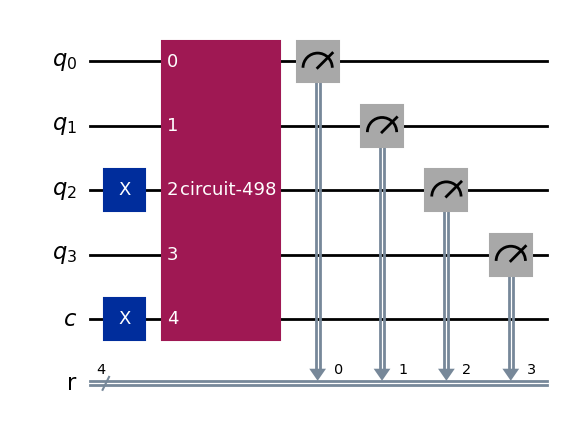

In [51]:
n = 4
q = QuantumRegister(n,name='q')
c = QuantumRegister(1,name='c')
r = ClassicalRegister(n,name='r')
qc = QuantumCircuit(q,c,r)

shift = shift_cycle_power_of_two(n,False)

qc.x(c)
qc.x(q[2])
qc.append(shift,qc.qubits)
qc.measure(q,r)
qc.decompose(reps=0).draw('mpl',style='iqx')

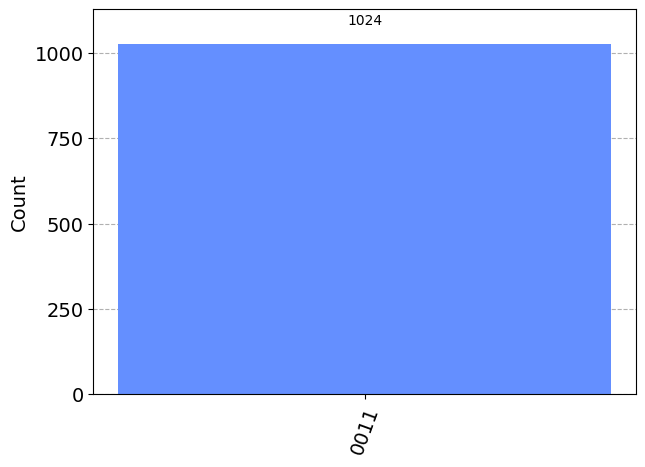

In [52]:
res = run_qc(qc,n_times=1024)
plot_histogram(res)

### Non power of two